# Kernel Density Estimation

## Sci-kit learn implementation

In [1]:
from sklearn.neighbors import KernelDensity

from scipy.stats.distributions import norm
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn
    Source: http://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [3]:
# Draw points from a bimodal distribution in 1D
N = 100000

np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(int(0.8 * N)),
                    norm(1, 0.3).rvs(int(0.2 * N))])

time to complete model 6.0361809730529785


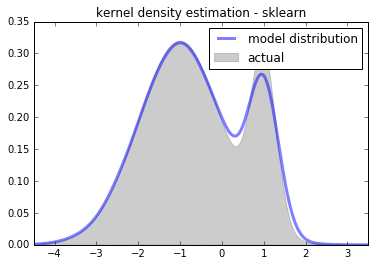

In [4]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

start = time.time()
pdf = kde_sklearn(x, x_grid, bandwidth=0.2)
print("time to complete model", time.time() - start)

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label="model distribution")
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label="actual")
plt.title("kernel density estimation - sklearn")
plt.legend(loc="best")
plt.xlim(-4.5, 3.5);

## Naive Python Implementation

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Draw points from a bimodal distribution in 1D
N = 100000

np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(int(0.8 * N)),
                    norm(1, 0.3).rvs(int(0.2 * N))])

In [7]:
# https://en.wikipedia.org/wiki/Kernel_density_estimation

def gaussian(x):
    return np.exp(-1.0 * (x**2) / 2) * (1.0 / np.sqrt(2.0 * np.pi))

In [8]:
def naive_kde(x, x_grid, h=0.2):
    
    global N
    # h is the bandwidth
    estimates = np.zeros(len(x_grid))
    
    for j, gridpt in enumerate(x_grid):
        for i in range(N):
            val_in_sum = gaussian((x[i] - gridpt) / h)
            estimates[j] += val_in_sum
        
        estimates[j] = estimates[j] / (N * h)
    
    return estimates

time to complete model 301.6976659297943


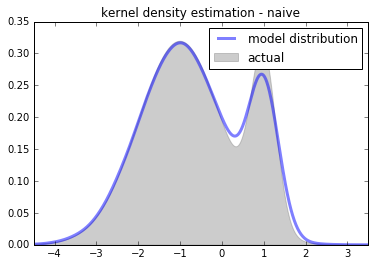

In [9]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

bandwidth = 0.2

start = time.time()
pdf = naive_kde(x, x_grid, bandwidth)
print("time to complete model", time.time() - start)

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label="model distribution")
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label="actual")
plt.title("kernel density estimation - naive")
plt.legend(loc="best")
plt.xlim(-4.5, 3.5);

Note that this seems like somewhat of an unfair comparison, due to the double loop. 

The ability to use `numpy` to vectorize the inner loop makes a huge difference; `numpy` is made for these types of calculations and in fact is used in the sklearn version. 

Note for this simplified task (1-D Gaussian kernel), we can write a vectorized version in numpy that even outperforms the sklearn version for the values of n that we tried, given that we can avoid the overhead of checking inputs to handle different kernels as well as the setting up of a tree structure.

In [10]:
def vectorized_kde(x, x_grid, h=0.2):
    
    global N
    # h is the bandwidth
    estimates = np.zeros(len(x_grid))
    
    for j, gridpt in enumerate(x_grid):
        val_in_sum = gaussian((x - gridpt)/h)  # returns vector of dim N
        estimates[j] = np.sum(val_in_sum) / (N * h)
    
    return estimates

time to complete model 1.297713041305542


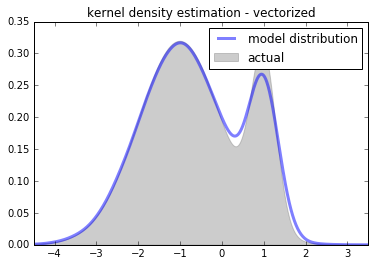

In [11]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

bandwidth = 0.2

start = time.time()
pdf = vectorized_kde(x, x_grid, bandwidth)
print("time to complete model", time.time() - start)

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label="model distribution")
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label="actual")
plt.title("kernel density estimation - vectorized")
plt.legend(loc="best")
plt.xlim(-4.5, 3.5);